In [35]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools
import math

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys
from CZwave2 import CZpulse

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0
opts = qt.solver.Options(nsteps=10000)

In [36]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [37]:
def paulis_set(Nq, n):
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=n))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for Two qubit gates
def _tr(Ope, p, q, paulis, Nq, n):
    
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(Wq)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b)
    a = Wp * c
    mat = a.full()
    return a.tr()

def agf(Ope, target, Nq, n):
    
    d = 2**n
    paulis = paulis_set(Nq, n)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq, n)/d
            u = _tr(target, p, q, paulis, Nq, n)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

## Pulse shape
---

In [38]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale

def MW_shaped(t,args):
    
    amp = args['mwamp']
    shape = args['shape'] 
    if int(t)>=len(shape):
        n=len(shape)-1
    else:
        n=int(t)
    return amp * shape[n]

## Parameters
---

In [39]:
# Q1
Ej1 = 17
Ec1 = 0.27
# Q2
Ej2 = 22
Ec2 = 0.27

###### qubit [GHz] ######
Nq = 3
Q1 = Tunabletransmon(EC=Ec1,EJmax=Ej1,Nq=Nq)
Q2 = Tunabletransmon(EC=Ec2,EJmax=Ej2,Nq=Nq)
wq1s=Q1.enes
wq2s=Q2.enes
fq1=wq1s[1]
fq2=wq2s[1]
print(fq1)
print(fq2)

J=0.015 #[GHz]
QQ=QQ(Q1,Q2,J)
pulsesystem=CZpulse(Q1,Q2,J,the_f=0.88,lambda2=0.13,gatetime=48)

5.775981884960281
6.611625529437035


## Hamiltonian assembling
---

In [40]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq1 = qt.qeye(Nq)
Iq2 = qt.qeye(Nq)
####### effective N-level pauli #######
pI = pI_N(Nq)
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

X1 = qt.tensor(px, Iq2)
Y1 = qt.tensor(py, Iq2)
Z1 = qt.tensor(pz, Iq2)
e_ops = [X1, Y1, Z1]

###### Assembling Lab frame Hamiltonian ######
# 2qubit-labframe
c1 = c(Nq)
C1 = qt.tensor(c1, Iq2)
c2 = c(Nq)
C2 = qt.tensor(Iq1,c2)

Hq1_lab = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2)
Hq2_lab = qt.tensor(Iq1,Hq_rot(Nq, wq2s, 0))
Hint = QQ.Hint12
Hlab = Hq1_lab + Hq2_lab + Hint

#2qubit-rotatingframe
#Hq1_rot = Hq1_lab
Hq1_rot = qt.tensor(Hq_rot(Nq, wq1s, fq1), Iq2)
rot2 = Hq_rot(Nq,[0,0,Q2.anh],fq1)
print(rot2)
q2Freqs = qt.qdiags(np.arange(0,Q2.Nq,1),0)
Hq2_t_ind = qt.tensor(Iq1, rot2) #Hq2_rot(constant term)
Hq2_t_dep = qt.tensor(Iq1, q2Freqs) #Hq2_rot(modulation term)
H_rot = [Hq1_rot + Hq2_t_ind + Hint, [Hq2_t_dep, MW_shaped]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.        ]
 [  0.          -5.77598188   0.        ]
 [  0.           0.         -11.8512038 ]]


In [41]:
initialH = Hq1_rot + Hq2_t_ind + Hint + Hq2_t_dep*pulsesystem.qFreq20
initialH

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.29924003  0.          0.015       0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.29924003  0.          0.0212132   0.
   0.          0.          0.        ]
 [ 0.          0.015       0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.0212132   0.          0.29924003  0.
   0.0212132   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.29924003
   0.          0.03        0.        ]
 [ 0.          0.          0.          0.          0.0212132   0.
  -0.30445979  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.03
   0.         -0.00521976  0.        ]
 [ 0.          0.          0.          0.          0. 

In [42]:
ini_state=qt.tensor(iniState1Qsys(Nq,1,'rho'),(px+pI)/2)
ini_state

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

In [43]:
###### Gate time ######
mwamp = pulsesystem.qFreq20
Tg = int(pi/(np.sqrt(2)*pulsesystem.J))
print(Tg)

squ = square(Tg, scale=1)

args = {'mwamp':mwamp, 'shape':squ}
t_step = Tg
t_list = np.linspace(0, Tg, Tg+1)

148


In [44]:
qproj = qt.qdiags([1 if i<2 else 0 for i in range(Nq)],0)
proj=qt.tensor(qproj,qproj)

# target Operator
onestate=iniState1Qsys(3,1,'rho')
cz=proj-2*qt.tensor(onestate,onestate)
cz

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]

In [45]:
_res = qt.mesolve(H_rot, ini_state, t_list, e_ops=[], args=args, options=opts, progress_bar=None)
#res = simple_prop(H_rot, t_list, [], args, 'sch')
res = qt.propagator(H_rot, t_list,[],args, parallel=False, options=qt.Options(nsteps=1000))
prop_fin=proj.dag()*res[-1]*proj
prop_fin

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.91484688-0.40296361j  0.        +0.j
  -0.00395273-0.02568665j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.00395296-0.02568815j  0.        +0.j
   0.99364792+0.1094915j   0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.    

## Fidelity

In [46]:
target = qt.to_super(cz)
Fave, Fe, prb = agf(qt.to_super(prop_fin), target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 95.92-0.00j


## Behavior of One Qubit State

In [47]:
r1=_res.states[-1].ptrace(0)
r1

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 3.44083339e-04+0.j         -2.69277165e-03+0.01269784j
   0.00000000e+00+0.j        ]
 [-2.69277165e-03-0.01269784j  9.98397200e-01+0.j
  -2.39314388e-02+0.00750958j]
 [ 0.00000000e+00+0.j         -2.39314388e-02-0.00750958j
   1.25871636e-03+0.j        ]]

In [48]:
r2=_res.states[-1].ptrace(1)
r2

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 5.00920863e-01+0.00000000e+00j -4.44767347e-01-2.26660639e-01j
   0.00000000e+00+0.00000000e+00j]
 [-4.44767347e-01+2.26660639e-01j  4.99072906e-01+0.00000000e+00j
   4.46681056e-05+9.99336109e-06j]
 [ 0.00000000e+00+0.00000000e+00j  4.46681056e-05-9.99336109e-06j
   6.23040430e-06+0.00000000e+00j]]

In [49]:
q1_evals=[]
q2_evals=[]
for state in _res.states:
    rho1=state.ptrace(0)
    _evals1=[qt.expect(px, rho1).real,qt.expect(py, rho1).real,qt.expect(pz, rho1).real]
    q1_evals.append(_evals1)
    rho2=state.ptrace(1)
    _evals2=[qt.expect(px, rho2).real,qt.expect(py, rho2).real,qt.expect(pz, rho2).real]
    q2_evals.append(_evals2)

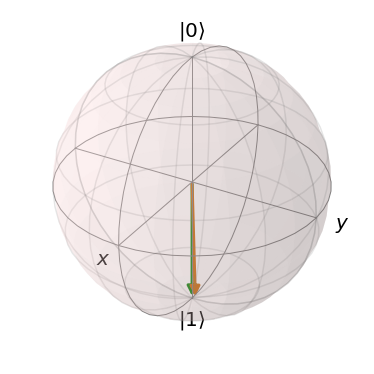

In [50]:
b1 = qt.Bloch()
b1.add_vectors([q1_evals[0][0], q1_evals[0][1], q1_evals[0][2]])
b1.add_vectors([q1_evals[-1][0], q1_evals[-1][1], q1_evals[-1][2]])
b1.show()

-0.8895346940339348 -0.4533212773218285 0.0018479572586805881


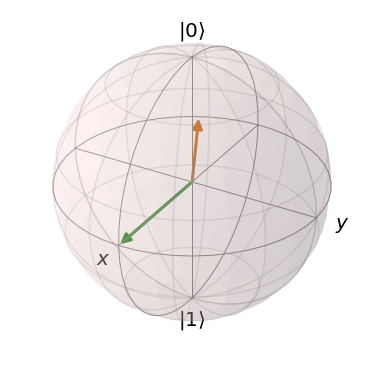

In [51]:
b2 = qt.Bloch()
b2.add_vectors([q2_evals[0][0], q2_evals[0][1], q2_evals[0][2]])
b2.add_vectors([q2_evals[-1][0], q2_evals[-1][1], q2_evals[-1][2]])
print(q2_evals[-1][0], q2_evals[-1][1], q2_evals[-1][2])
b2.show()